In [63]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [64]:
start = datetime(2001,1,1)
end  = datetime(2023,1,1)
current_date = datetime(2023,1,1)

In [65]:
market = Market()

In [66]:
pricer_classes = [] 
# pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
# pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
# pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
# pricer_classes.append(Pricer.MONTHLY_STOCK_ROLLING)
# pricer_classes.append(Pricer.MONTHLY_STOCK_WINDOW)
# pricer_classes.append(Pricer.QUARTERLY_STOCK_ROLLING)
# pricer_classes.append(Pricer.QUARTERLY_STOCK_WINDOW)

In [67]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [68]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [69]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 10%|████████████████▊                                                                                                                                                   | 37/361 [00:19<02:42,  1.99it/s]


 21%|██████████████████████████████████▌                                                                                                                                 | 76/361 [00:39<02:23,  1.99it/s]


 32%|███████████████████████████████████████████████████▉                                                                                                               | 115/361 [00:59<02:07,  1.93it/s]


 43%|█████████████████████████████████████████████████████████████████████▌                                                                                             | 154/361 [01:18<01:47,  1.93it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 193/361 [01:38<01:26,  1.94it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 232/361 [01:59<01:06,  1.95it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 271/361 [02:19<00:45,  1.96it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 311/361 [02:39<00:26,  1.91it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 350/361 [02:59<00:05,  1.92it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:05<00:00, 185.83s/it]


In [70]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,date,status,trade_algo,pv,beta,rrr,sharpe
176,True,False,False,False,none,1.0,tyield10,1.0,176.0,NaN,NaN,wsr_n_n_b_r,3628.875201,-0.182851,NaN,-19840.586588
171,True,False,False,False,none,1.0,tyield2,1.0,171.0,NaN,NaN,wsr_n_n_b_r,3628.875201,-0.182851,NaN,-19840.586588
166,True,False,False,False,none,1.0,tyield1,1.0,166.0,NaN,NaN,wsr_n_n_b_r,3628.875201,-0.182851,NaN,-19840.586588
161,True,False,False,False,none,0.5,tyield10,1.0,161.0,NaN,NaN,wsr_n_n_b_r,3628.875201,-0.182851,NaN,-19840.586588
156,True,False,False,False,none,0.5,tyield2,1.0,156.0,NaN,NaN,wsr_n_n_b_r,3628.875201,-0.182851,NaN,-19840.586588
151,True,False,False,False,none,0.5,tyield1,1.0,151.0,NaN,NaN,wsr_n_n_b_r,3628.875201,-0.182851,NaN,-19840.586588
126,True,False,False,False,flat,0.5,tyield2,1.0,126.0,NaN,NaN,wsr_n_n_b_r,3621.506743,-0.183417,NaN,-19739.193163
146,True,False,False,False,flat,1.0,tyield10,1.0,146.0,NaN,NaN,wsr_n_n_b_r,3621.506743,-0.183417,NaN,-19739.193163
141,True,False,False,False,flat,1.0,tyield2,1.0,141.0,NaN,NaN,wsr_n_n_b_r,3621.506743,-0.183417,NaN,-19739.193163
121,True,False,False,False,flat,0.5,tyield1,1.0,121.0,NaN,NaN,wsr_n_n_b_r,3621.506743,-0.183417,NaN,-19739.193163


In [71]:
a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,date,status,pv,beta,rrr,sharpe
0,wsr_n_n_b_r,True,False,False,False,none,1.0,tyield10,1.0,176.0,NaN,NaN,3628.875201,-0.182851,NaN,-19840.586588


In [72]:
for row in a.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [73]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [74]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max())/5)
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [75]:
ledger

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,1,BKNG,26.340992,1.0,1.283688,0,Consumer Discretionary,Booking Holdings
1,2001,2,BKNG,21.185321,1.0,1.845304,0,Consumer Discretionary,Booking Holdings
2,2001,3,BKNG,10.277071,1.0,0.751429,0,Consumer Discretionary,Booking Holdings
3,2001,4,BKNG,10.911184,1.0,1.129278,0,Consumer Discretionary,Booking Holdings
4,2001,5,BKNG,10.934624,1.0,1.000000,0,Consumer Discretionary,Booking Holdings
...,...,...,...,...,...,...,...,...,...
23077,2023,24,CF,0.289998,1.0,1.049820,19,Materials,CF Industries
23078,2023,25,TSN,0.274188,1.0,1.002609,19,Consumer Staples,Tyson Foods
23079,2023,26,PARA,0.280702,1.0,1.017003,19,Communication Services,Paramount Global
23080,2023,28,CF,0.236620,1.0,1.048476,19,Materials,CF Industries


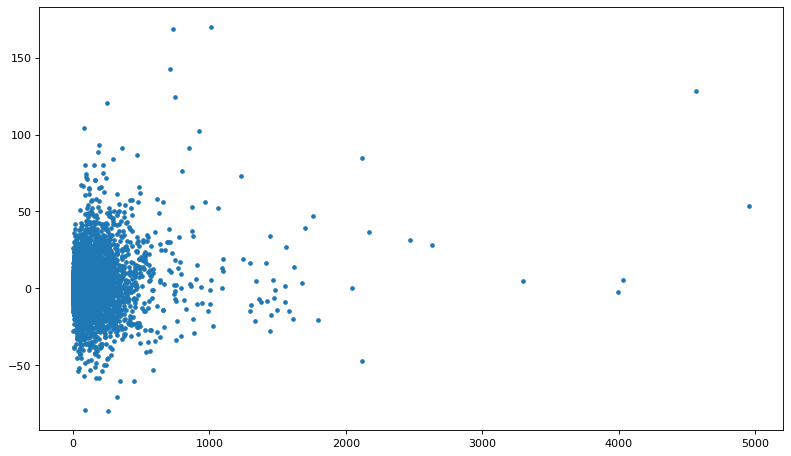

In [76]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [77]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,1,BKNG,26.340992,1.0,1.283688,0,Consumer Discretionary,Booking Holdings
1160,2001,1,FFIV,4.332356,1.0,1.097561,1,Information Technology,"F5, Inc."
2320,2001,1,AKAM,3.927581,1.0,1.041013,2,Information Technology,Akamai
3480,2001,1,AAPL,2.011755,1.0,1.155242,3,Information Technology,Apple Inc.
4640,2001,1,AMZN,1.862013,1.0,1.180115,4,Consumer Discretionary,Amazon
5800,2001,1,LRCX,1.204713,1.0,1.317107,5,Information Technology,Lam Research
6960,2001,1,AMD,1.132387,1.0,1.164812,6,Information Technology,AMD
8120,2001,1,VRSN,1.108936,1.0,1.183142,7,Information Technology,Verisign
9280,2001,1,WDC,1.107788,1.0,1.540424,8,Information Technology,Western Digital
10440,2001,1,BBY,1.028500,1.0,1.437500,9,Consumer Discretionary,Best Buy


In [78]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
1561,2008,44,LVS,10.135932,1.0,2.703030,1,Consumer Discretionary,Las Vegas Sands
386,2008,29,UAL,7.367012,1.0,2.686901,0,Industrials,United Airlines Holdings
1546,2008,29,AAL,7.081647,1.0,2.426136,1,Industrials,American Airlines Group
418,2009,11,AIG,45.643656,1.0,2.285714,0,Financials,American International Group
2725,2008,49,HIG,7.472210,1.0,2.244444,2,Financials,Hartford (The)
2745,2009,18,MGM,2.496982,1.0,2.206897,2,Consumer Discretionary,MGM Resorts
123,2003,22,ILMN,0.832584,1.0,2.043902,0,Health Care,Illumina
79,2002,30,WMB,9.204873,1.0,2.025210,0,Energy,Williams Companies
2719,2008,42,UAL,1.891089,1.0,1.935484,2,Industrials,United Airlines Holdings
1176,2001,17,BKNG,3.579491,1.0,1.915698,1,Consumer Discretionary,Booking Holdings


In [79]:
ledger["actual_returns"].mean()

1.0075079138140213

In [80]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5350056320942725

In [81]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [82]:
portfolio.head(20)

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,1,1.283688,1.097561,1.041013,1.155242,1.180115,1.317107,1.164812,1.183142,...,1.142857,1.114626,1.101266,1.105664,1.063830,1.038313,1.097744,1.043306,1.053333,1.021728
1,2001,2,1.845304,1.574903,1.144889,1.122100,0.977894,1.210174,1.031250,1.295686,...,1.104478,0.875000,1.002218,0.945736,1.089041,0.797394,1.050364,1.191130,1.107816,0.955696
2,2001,3,0.751429,1.041459,1.013885,1.197430,1.049280,0.914985,1.191961,0.950498,...,1.031992,1.302393,1.085734,1.111930,1.038975,1.107273,1.043478,1.183729,1.105882,1.096087
3,2001,4,1.129278,1.244427,0.955182,0.999472,1.060976,1.645714,1.044430,0.985000,...,0.974191,1.101720,1.003571,1.086839,1.001250,0.891391,0.979149,1.154993,0.920750,0.938782
4,2001,5,1.000000,0.888036,0.840991,0.834741,0.971034,0.884334,0.939086,0.940789,...,0.890972,0.958390,0.975361,0.874905,0.772063,0.944247,0.805722,0.937143,0.916834,0.973545
5,2001,6,0.895623,0.888803,0.801873,0.869703,0.841157,0.905303,0.884358,0.876808,...,0.918919,0.932568,0.947242,0.899085,0.915350,1.000961,1.044814,1.011307,0.912217,0.902174
6,2001,7,0.906015,0.797394,0.782040,0.868364,0.875777,0.864449,0.986925,0.881754,...,0.766119,1.080273,0.823529,0.715114,0.961538,0.808282,0.877468,0.915531,1.130424,0.903916
7,2001,8,1.011029,0.808416,0.899495,0.940000,0.855798,0.953411,1.057892,1.007761,...,0.914286,0.836437,0.840936,1.066194,0.890511,0.835519,0.869565,1.037552,0.937705,0.922392
8,2001,9,1.000000,0.992032,0.705222,1.011064,1.010376,0.915937,0.875000,1.004212,...,1.203333,1.018365,1.109964,1.019090,0.934426,1.157619,1.086207,1.124126,1.251355,1.064220
9,2001,10,0.865455,0.777303,0.910828,0.778233,0.762580,0.925926,0.927501,0.793548,...,0.960702,0.960862,0.821990,1.160714,0.909767,0.861017,0.932698,0.908864,0.965723,0.982893


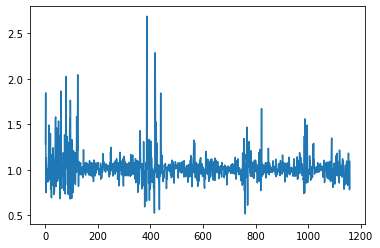

In [83]:
plt.plot(portfolio[0])

In [84]:
positions = 20

In [85]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [86]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,year,week,pv,daily_returns,adjclose,bench,date_string,date
5527,82325.612609,29.574441,160.421106,3.579993,31.019160,98.011265,17.115779,2.365698,94.125725,815.328322,...,33.924631,18.709004,2023,26,4216.652262,1.027863,13492.52,NaN,2023-W26,2023-06-30
5528,64428.740303,29.336236,148.915040,3.865094,30.642028,99.181093,18.243705,2.502263,99.688340,883.905688,...,33.500369,19.615936,2023,28,3325.325873,1.011489,13816.77,NaN,2023-W28,2023-07-14
5529,64428.740303,29.336236,148.915040,3.865094,30.642028,99.181093,18.243705,2.502263,99.688340,883.905688,...,33.500369,19.615936,2023,28,3325.325873,1.011489,13791.65,NaN,2023-W28,2023-07-14
5530,64428.740303,29.336236,148.915040,3.865094,30.642028,99.181093,18.243705,2.502263,99.688340,883.905688,...,33.500369,19.615936,2023,28,3325.325873,1.011489,13679.04,NaN,2023-W28,2023-07-14
5531,64428.740303,29.336236,148.915040,3.865094,30.642028,99.181093,18.243705,2.502263,99.688340,883.905688,...,33.500369,19.615936,2023,28,3325.325873,1.011489,13660.72,NaN,2023-W28,2023-07-14
5532,70394.364405,30.284341,170.820819,4.193500,29.683482,99.301686,20.128269,2.571557,95.111870,937.133155,...,35.474818,19.610614,2023,29,3628.875201,1.035163,13685.48,NaN,2023-W29,2023-07-21
5533,70394.364405,30.284341,170.820819,4.193500,29.683482,99.301686,20.128269,2.571557,95.111870,937.133155,...,35.474818,19.610614,2023,29,3628.875201,1.035163,13760.70,NaN,2023-W29,2023-07-21
5534,70394.364405,30.284341,170.820819,4.193500,29.683482,99.301686,20.128269,2.571557,95.111870,937.133155,...,35.474818,19.610614,2023,29,3628.875201,1.035163,13918.96,NaN,2023-W29,2023-07-21
5535,70394.364405,30.284341,170.820819,4.193500,29.683482,99.301686,20.128269,2.571557,95.111870,937.133155,...,35.474818,19.610614,2023,29,3628.875201,1.035163,14138.57,NaN,2023-W29,2023-07-21
5536,70394.364405,30.284341,170.820819,4.193500,29.683482,99.301686,20.128269,2.571557,95.111870,937.133155,...,35.474818,19.610614,2023,29,3628.875201,1.035163,14113.70,NaN,2023-W29,2023-07-21


In [87]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [88]:
cash_analysis["cash"].sum()

11498.155556944746

In [89]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.159164,NaN,NaN,0.000000,0.000000
1,1.143972,1.0,1.143972,14.397235,14.397235
2,1.143972,1.0,1.143972,14.397235,28.794469
3,1.143972,1.0,1.143972,14.397235,43.191704
4,1.143972,1.0,1.143972,14.397235,57.588938
...,...,...,...,...,...
5532,1.035163,1.0,1.035163,3.516294,11484.090381
5533,1.035163,1.0,1.035163,3.516294,11487.606675
5534,1.035163,1.0,1.035163,3.516294,11491.122969
5535,1.035163,1.0,1.035163,3.516294,11494.639263


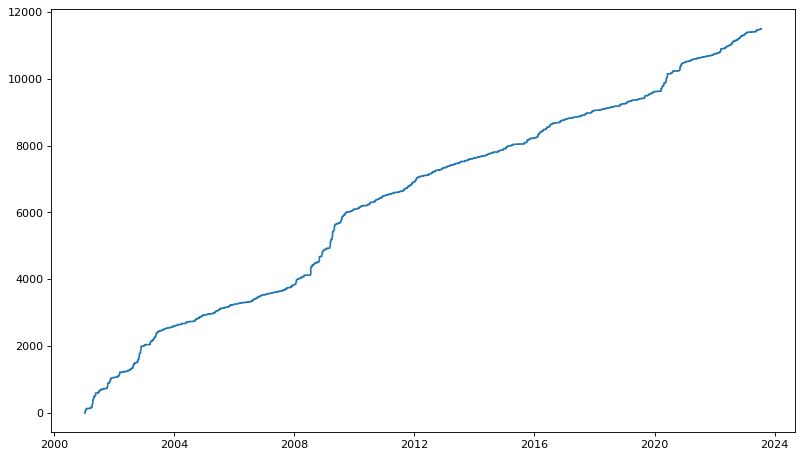

In [90]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

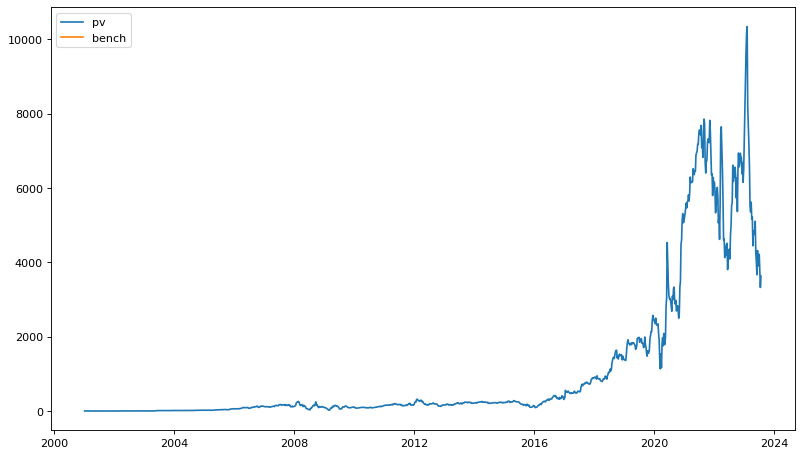

In [91]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [92]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,18,19,year,week,pv,daily_returns,adjclose,bench,date_string,date
0,1.283688,1.097561,1.041013,1.155242,1.180115,1.317107,1.164812,1.183142,1.540424,1.437500,...,1.053333,1.021728,2001,1,1.159164,1.159164,2291.86,NaN,2001-W1,2001-01-05
1,2.368794,1.728552,1.191844,1.296297,1.154028,1.593928,1.201213,1.532980,2.087271,1.729853,...,1.166900,0.976462,2001,2,1.339865,1.143972,2291.86,NaN,2001-W2,2001-01-12
2,2.368794,1.728552,1.191844,1.296297,1.154028,1.593928,1.201213,1.532980,2.087271,1.729853,...,1.166900,0.976462,2001,2,1.339865,1.143972,2616.69,NaN,2001-W2,2001-01-12
3,2.368794,1.728552,1.191844,1.296297,1.154028,1.593928,1.201213,1.532980,2.087271,1.729853,...,1.166900,0.976462,2001,2,1.339865,1.143972,2566.83,NaN,2001-W2,2001-01-12
4,2.368794,1.728552,1.191844,1.296297,1.154028,1.593928,1.201213,1.532980,2.087271,1.729853,...,1.166900,0.976462,2001,2,1.339865,1.143972,2407.65,NaN,2001-W2,2001-01-12
5,2.368794,1.728552,1.191844,1.296297,1.154028,1.593928,1.201213,1.532980,2.087271,1.729853,...,1.166900,0.976462,2001,2,1.339865,1.143972,1950.40,NaN,2001-W2,2001-01-12
6,1.779980,1.800216,1.208392,1.552225,1.210898,1.458420,1.431798,1.457094,2.357283,1.950357,...,1.290454,1.070287,2001,3,1.414799,1.073761,2395.92,NaN,2001-W3,2001-01-19
7,1.779980,1.800216,1.208392,1.552225,1.210898,1.458420,1.431798,1.457094,2.357283,1.950357,...,1.290454,1.070287,2001,3,1.414799,1.073761,2441.30,NaN,2001-W3,2001-01-19
8,1.779980,1.800216,1.208392,1.552225,1.210898,1.458420,1.431798,1.457094,2.357283,1.950357,...,1.290454,1.070287,2001,3,1.414799,1.073761,2524.18,NaN,2001-W3,2001-01-19
9,1.779980,1.800216,1.208392,1.552225,1.210898,1.458420,1.431798,1.457094,2.357283,1.950357,...,1.290454,1.070287,2001,3,1.414799,1.073761,2640.57,NaN,2001-W3,2001-01-19


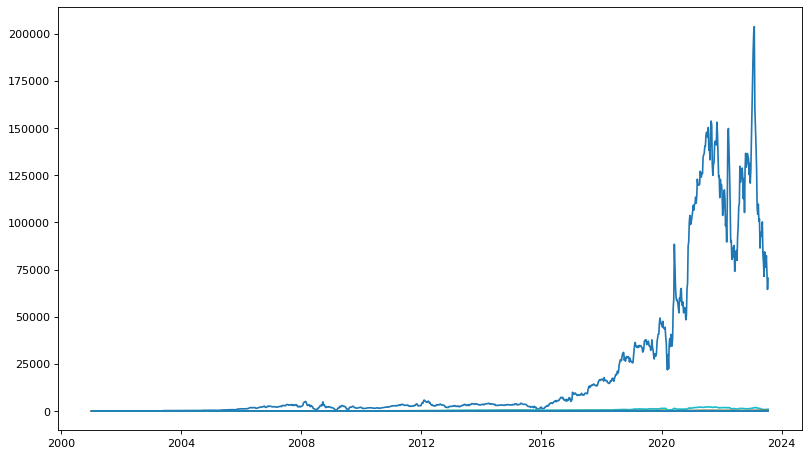

In [93]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [94]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Financials,2010.871140,27.191693,0.911629,1.0,1.013057,10.295527
Industrials,2011.736289,27.072669,0.503222,1.0,1.010020,10.060329
Health Care,2010.251854,26.211213,0.347992,1.0,1.009858,9.318896
Consumer Discretionary,2013.517197,26.675565,0.514693,1.0,1.008088,9.051078
Consumer Staples,2013.059719,25.462529,0.173144,1.0,1.007927,10.969555
Real Estate,2010.766667,25.862393,0.855752,1.0,1.007487,9.781197
Energy,2015.183962,26.866745,0.508584,1.0,1.005825,9.973467
Information Technology,2009.831090,25.609690,0.578350,1.0,1.005277,8.948632
Materials,2012.604185,27.365301,0.368077,1.0,1.004068,9.701831


In [95]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year week ticker Security                                     
2008 44   LVS    Las Vegas Sands                  10.135932   
     29   UAL    United Airlines Holdings          7.367012   
          AAL    American Airlines Group           7.081647   
2009 11   AIG    American International Group     45.643656   
2008 49   HIG    Hartford (The)                    7.472210   
2009 18   MGM    MGM Resorts                       2.496982   
2003 22   ILMN   Illumina                          0.832584   
2002 30   WMB    Williams Companies                9.204873   
2008 42   UAL    United Airlines Holdings          1.891089   
2001 17   BKNG   Booking Holdings                  3.579491   
2009 14   MGM    MGM Resorts                       8.519258   
2001 15   SBAC   SBA Communications                1.865186   
2002 10   SBAC   SBA Communications                4.690664   
2001 2    BKNG   Booking Holdings                 21.185321   
2009 32   AIG    American International Group      2.910081   
2008 49   DXCM   Dexcom                            2.232258   
2020 12   PENN   Penn National Gaming              1.574562   
2009 19   FITB   Fifth Third Bank                  0.856661   
2002 46   SBAC   SBA Communications                8.016767   
2009 15   HBAN   Huntington National Bank          2.222015   
2008 29   BAC    Bank of America                   0.939420   
2009 11   C      Citigroup                        12.296831   
     19   HBAN   Huntington National Bank          0.986227   
2008 48   F      Ford Motor Company                2.415679   
     29   ALK    Alaska Air Group                  1.051377   
2002 46   AMT    American Tower                    1.644033   
2008 29   HBAN   Huntington National Bank          1.614140   
2017 2    ENPH   Enphase                           0.625091   
2002 47   ALGN   Align Technology                  0.763057   
     43   AMT    American Tower                    4.809640   

                                               weekly_delta_sign  \
year week ticker Security                                          
2008 44   LVS    Las Vegas Sands                             1.0   
     29   UAL    United Airlines Holdings                    1.0   
          AAL    American Airlines Group                     1.0   
2009 11   AIG    American International Group                1.0   
2008 49   HIG    Hartford (The)                              1.0   
2009 18   MGM    MGM Resorts                                 1.0   
2003 22   ILMN   Illumina                                    1.0   
2002 30   WMB    Williams Companies                          1.0   
2008 42   UAL    United Airlines Holdings                    1.0   
2001 17   BKNG   Booking Holdings                            1.0   
2009 14   MGM    MGM Resorts                                 1.0   
2001 15   SBAC   SBA Communications                          1.0   
2002 10   SBAC   SBA Communications                          1.0   
2001 2    BKNG   Booking Holdings                            1.0   
2009 32   AIG    American International Group                1.0   
2008 49   DXCM   Dexcom                                      1.0   
2020 12   PENN   Penn National Gaming                        1.0   
2009 19   FITB   Fifth Third Bank                            1.0   
2002 46   SBAC   SBA Communications                          1.0   
2009 15   HBAN   Huntington National Bank                    1.0   
2008 29   BAC    Bank of America                             1.0   
2009 11   C      Citigroup                                   1.0   
     19   HBAN   Huntington National Bank                    1.0   
2008 48   F      Ford Motor Company                          1.0   
     29   ALK    Alaska Air Group                            1.0   
2002 46   AMT    American Tower                              1.0   
2008 29   HBAN   Huntington National Bank                    1.0   
2017 2    ENPH   Enphase                                  

In [96]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,1,1.114626,1.251742,1.000000,1.000000,1.000000,1.063830,1.000000,1.142703,1.000000,1.000000,1.000000
1,4004001,2,1.510316,1.778763,1.000000,1.000000,1.000000,1.188631,1.000000,1.250763,1.000000,1.000000,0.797394
2,8012006001,6,1.510316,1.769535,1.000000,1.000000,1.000000,1.369238,1.000000,1.364396,1.000000,1.000000,0.729604
3,16032024008001,24,1.510316,1.883449,1.000000,1.000000,1.000000,1.309658,1.000000,1.420173,1.001250,1.000000,1.200719
4,32080080040010001,120,1.510316,1.727821,1.000000,1.000000,1.000000,1.141278,1.000000,1.296924,0.994062,1.000000,1.069808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0,0,8.692578,309.898721,49.416403,2.209548,55.700494,3639.314061,40.494386,37.528012,7.083141,11.868392,0.319767
1156,0,0,8.480938,315.247143,49.545324,2.209548,54.703785,3535.152276,40.494386,36.787230,7.077029,13.318549,0.319767
1157,0,0,8.932030,315.179137,49.545324,2.209548,55.878512,3792.747264,40.494386,39.040404,7.172775,13.318549,0.319767
1158,0,0,7.640836,312.398175,49.545324,2.209548,59.199658,3785.743011,40.494386,41.320847,7.395779,13.318549,0.319767
